# Stage 1: Unseen Dataset Evaluation
## DualCircuit PI-HLNN (**No FP_AMPL**) — LOS/NLOS Classification

This notebook loads the trained Stage 1 model **without FP conditioning** (`stage1_pi_hlnn_no_fp_best.pt`) and evaluates it on a **completely unseen dataset** containing 4 scenarios never used during training:

| Scenario | Type | d_direct | d_bounce | Samples |
|----------|------|----------|----------|---------|
| 8.91m | NLOS | 6.10m | 8.91m | 600 |
| 9.54m | NLOS | 7.668m | 9.54m | 600 |
| 10.19m | LOS | 10.19m | — | 600 |
| 9.29m | LOS | 9.29m | — | 600 |

**Total: 2400 samples (1200 LOS + 1200 NLOS), perfectly balanced.**

**Key difference from original PI-HLNN**: No FP_AMPL conditioning — h₀ = zeros(32) for both circuits.

In [1]:
CONFIG = {
    "pre_crop": 10,
    "post_crop": 50,
    "total_len": 60,
    "search_start": 740,
    "search_end": 890,
    "hidden_size": 32,
    "input_size": 1,
    "dropout": 0.2,
    "ode_unfolds": 6,
    "batch_size": 64,
    "seed": 42,
}

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

Device: cuda


## 1 · Model Architecture
Identical definition from `stage1_pi_hlnn_no_fp.ipynb` — required to load the `.pt` weights.
**No `fp_to_los_init` / `fp_to_nlos_init`** — both circuits start from zeros.

In [3]:
class PILiquidCell(nn.Module):
    """
    Conductance-based LTC cell (Hasani et al. 2020).
    Identical to the original — no changes.
    """
    def __init__(self, input_size, hidden_size, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size  = input_size
        self.ode_unfolds = ode_unfolds

        self.gleak = nn.Parameter(torch.empty(hidden_size).uniform_(0.001, 1.0))
        self.vleak = nn.Parameter(torch.empty(hidden_size).uniform_(-0.2, 0.2))
        self.cm    = nn.Parameter(torch.empty(hidden_size).uniform_(0.4, 0.6))

        self.w     = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.001, 1.0))
        self.erev  = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(-0.2, 0.2))
        self.mu    = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.3, 0.8))
        self.sigma = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(3, 8))

        self.sensory_w     = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.001, 1.0))
        self.sensory_mu    = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.3, 0.8))
        self.sensory_sigma = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(3, 8))

    def forward(self, x_t, h_prev, dt=1.0):
        gleak     = F.softplus(self.gleak)
        cm        = F.softplus(self.cm)
        w         = F.softplus(self.w)
        sensory_w = F.softplus(self.sensory_w)

        sensory_gate    = torch.sigmoid(self.sensory_sigma * (x_t.unsqueeze(-1) - self.sensory_mu))
        sensory_current = (sensory_w * sensory_gate * x_t.unsqueeze(-1)).sum(dim=1)

        cm_t = cm / (dt / self.ode_unfolds)
        v    = h_prev

        for _ in range(self.ode_unfolds):
            recurrent_gate = torch.sigmoid(self.sigma.unsqueeze(0) * (v.unsqueeze(2) - self.mu.unsqueeze(0)))
            w_gate = w.unsqueeze(0) * recurrent_gate
            w_num  = (w_gate * self.erev.unsqueeze(0)).sum(dim=1)
            w_den  = w_gate.sum(dim=1)
            numerator   = cm_t * v + gleak * self.vleak + w_num + sensory_current
            denominator = cm_t + gleak + w_den + 1e-8
            v = numerator / denominator
            v = torch.clamp(v, -1.0, 1.0)

        tau = cm / (gleak + w_den + 1e-8)
        return v, tau

In [4]:
class DualCircuit_PI_HLNN_NoFP(nn.Module):
    """
    Dual-circuit PI-HLNN WITHOUT FP_AMPL conditioning.
    Both circuits always start from h₀ = zeros(32).
    Uses average pooling (matching the original PI-HLNN).
    """
    def __init__(self, input_size=1, hidden_size=32, dropout=0.2, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size

        self.cell_los  = PILiquidCell(input_size, hidden_size, ode_unfolds)
        self.cell_nlos = PILiquidCell(input_size, hidden_size, ode_unfolds)

        # NO fp_to_los_init / fp_to_nlos_init

        self.P_nlos2los = nn.Linear(hidden_size, hidden_size, bias=False)
        self.P_los2nlos = nn.Linear(hidden_size, hidden_size, bias=False)

        self.gate_los  = nn.Linear(hidden_size * 2, hidden_size)
        self.gate_nlos = nn.Linear(hidden_size * 2, hidden_size)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def _run_circuits(self, x_seq):
        batch_size, seq_len, _ = x_seq.size()

        h_los  = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
        h_nlos = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)

        los_states, nlos_states = [], []
        tau_los_sum  = torch.zeros_like(h_los)
        tau_nlos_sum = torch.zeros_like(h_nlos)
        tau_los_hist_list, tau_nlos_hist_list = [], []

        for t in range(seq_len):
            x_t = x_seq[:, t, :]

            proj_nlos_to_los = self.P_nlos2los(h_nlos)
            proj_los_to_nlos = self.P_los2nlos(h_los)

            g_los  = torch.sigmoid(self.gate_los( torch.cat([h_los,  proj_nlos_to_los], dim=1)))
            g_nlos = torch.sigmoid(self.gate_nlos(torch.cat([h_nlos, proj_los_to_nlos], dim=1)))

            h_los_in  = h_los  + g_los  * proj_nlos_to_los
            h_nlos_in = h_nlos + g_nlos * proj_los_to_nlos

            h_los,  tau_los  = self.cell_los( x_t, h_los_in)
            h_nlos, tau_nlos = self.cell_nlos(x_t, h_nlos_in)

            los_states.append(h_los.unsqueeze(1))
            nlos_states.append(h_nlos.unsqueeze(1))
            tau_los_sum  += tau_los
            tau_nlos_sum += tau_nlos
            tau_los_hist_list.append(tau_los.unsqueeze(1))
            tau_nlos_hist_list.append(tau_nlos.unsqueeze(1))

        los_all  = torch.cat(los_states,  dim=1)
        nlos_all = torch.cat(nlos_states, dim=1)
        tau_los_mean  = tau_los_sum  / seq_len
        tau_nlos_mean = tau_nlos_sum / seq_len
        tau_los_hist  = torch.cat(tau_los_hist_list,  dim=1)
        tau_nlos_hist = torch.cat(tau_nlos_hist_list, dim=1)
        return los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean

    def _pool_and_fuse(self, los_all, nlos_all):
        """Time-average the ODE trajectory from each circuit — no attention pooling.
           Computes (1/T) Σ h(t), a standard dynamical-systems observable that
           summarises the continuous-time hidden-state evolution."""
        h_los_avg  = los_all.mean(dim=1)   # (batch, hidden)
        h_nlos_avg = nlos_all.mean(dim=1)  # (batch, hidden)
        return torch.cat([h_los_avg, h_nlos_avg], dim=1)   # (batch, 2*hidden)

    def forward(self, x_seq, return_dynamics=False):
        los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean = \
            self._run_circuits(x_seq)
        h_fused = self._pool_and_fuse(los_all, nlos_all)
        pred = self.classifier(h_fused)
        if return_dynamics:
            return pred, los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean
        return pred, tau_los_mean, tau_nlos_mean

    def embed(self, x_seq):
        """Return 64-dim fused embedding for Stage 2/3."""
        los_all, nlos_all, _, _, _, _ = self._run_circuits(x_seq)
        return self._pool_and_fuse(los_all, nlos_all)

## 2 · Load Unseen Dataset
Same preprocessing as training: RXPACC normalization → leading-edge alignment → 60-sample crop → instance normalization to [0,1].

**No FP_AMPL features** — CIR only.

In [5]:
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


def load_unseen_dataset(filepath):
    """Load and preprocess the unseen dataset — CIR only, no FP features."""
    PRE = CONFIG["pre_crop"]
    TOTAL = CONFIG["total_len"]

    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} rows from {filepath}")

    cir_cols = sorted(
        [c for c in df.columns if c.startswith("CIR")],
        key=lambda c: int(c.replace("CIR", ""))
    )

    X_list, y_list = [], []
    source_files = []
    skipped = 0

    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc <= 0:
            skipped += 1
            continue
        sig = sig / rxpacc

        leading_edge = get_roi_alignment(sig)
        start = max(0, leading_edge - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        local_min = np.min(crop)
        local_max = np.max(crop)
        rng = local_max - local_min
        if rng > 0:
            crop = (crop - local_min) / rng
        else:
            crop = np.zeros(TOTAL)

        X_list.append(crop)
        y_list.append(float(row["Label"]))
        source_files.append(row["Source_File"])

    if skipped:
        print(f"Skipped {skipped} rows (bad RXPACC)")

    X = np.array(X_list, dtype=np.float32).reshape(-1, TOTAL, 1)
    y = np.array(y_list, dtype=np.float32)

    print(f"Preprocessed: {len(y)} samples  |  LOS: {int((y==0).sum())}  |  NLOS: {int((y==1).sum())}")
    return X, y, source_files

In [6]:
X_unseen, y_unseen, sources = load_unseen_dataset(
    "../dataset/channels/unseen_dataset.csv"
)

Loaded 2400 rows from ../dataset/channels/unseen_dataset.csv
Preprocessed: 2400 samples  |  LOS: 1200  |  NLOS: 1200


## 3 · Load Trained Model

In [7]:
model = DualCircuit_PI_HLNN_NoFP(
    input_size=CONFIG["input_size"],
    hidden_size=CONFIG["hidden_size"],
    dropout=CONFIG["dropout"],
    ode_unfolds=CONFIG["ode_unfolds"],
).to(device)

state_dict = torch.load("stage1_pi_hlnn_no_fp_best.pt", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f"Model loaded: {total_params:,} parameters")
print(f"FP conditioning: NONE (zero-init h₀)")

Model loaded: 16,897 parameters
FP conditioning: NONE (zero-init h₀)


## 4 · Inference on Unseen Data

In [8]:
X_te = torch.tensor(X_unseen).to(device)
y_te = torch.tensor(y_unseen).unsqueeze(1).to(device)

with torch.no_grad():
    pred, tau_los_mean, tau_nlos_mean = model(X_te)
    pred_binary = (pred > 0.5).float()
    accuracy = (pred_binary == y_te).float().mean().item()

pred_np = pred.cpu().numpy().flatten()
pred_label_np = (pred_np > 0.5).astype(float)
true_np = y_unseen.flatten()

print(f"Unseen Dataset Accuracy: {100 * accuracy:.2f}%")
print(f"{'='*50}")
print(classification_report(true_np, pred_label_np, target_names=["LOS", "NLOS"]))

Unseen Dataset Accuracy: 89.08%
              precision    recall  f1-score   support

         LOS       0.83      0.99      0.90      1200
        NLOS       0.99      0.79      0.88      1200

    accuracy                           0.89      2400
   macro avg       0.91      0.89      0.89      2400
weighted avg       0.91      0.89      0.89      2400



## 5 · Per-Scenario Breakdown

In [9]:
sources_arr = np.array(sources)

scenario_names = np.array(["_".join(s.split("_")[:2]) for s in sources_arr])
unique_scenarios = sorted(set(scenario_names))

print(f"{'Scenario':<16} {'Type':<6} {'Samples':>7} {'Correct':>8} {'Accuracy':>9}")
print("-" * 52)

for scenario in unique_scenarios:
    mask = scenario_names == scenario
    s_true = true_np[mask]
    s_pred = pred_label_np[mask]
    s_correct = (s_true == s_pred).sum()
    s_total = len(s_true)
    s_acc = s_correct / s_total * 100
    s_type = "NLOS" if "nlos" in scenario else "LOS"
    print(f"{scenario:<16} {s_type:<6} {s_total:>7} {s_correct:>8} {s_acc:>8.2f}%")

print("-" * 52)
print(f"{'TOTAL':<16} {'':6} {len(true_np):>7} {int((true_np == pred_label_np).sum()):>8} {100*accuracy:>8.2f}%")

Scenario         Type   Samples  Correct  Accuracy
----------------------------------------------------
10.19m_los       LOS        600      587    97.83%
8.91m_nlos       NLOS       600      600   100.00%
9.29m_los        LOS        600      600   100.00%
9.54m_nlos       NLOS       600      351    58.50%
----------------------------------------------------
TOTAL                      2400     2138    89.08%


## 6 · Confusion Matrix

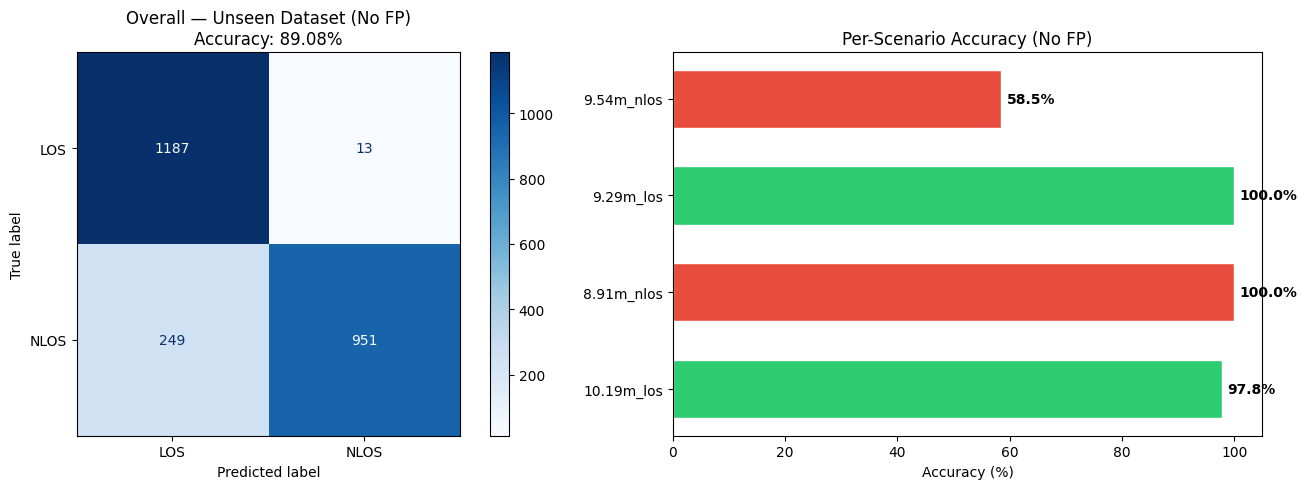

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall confusion matrix
cm = confusion_matrix(true_np, pred_label_np)
disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
disp.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title(f"Overall — Unseen Dataset (No FP)\nAccuracy: {100*accuracy:.2f}%")

# Per-scenario accuracy bar chart
scenario_labels, scenario_accs, scenario_colors = [], [], []
for scenario in unique_scenarios:
    mask = scenario_names == scenario
    s_acc = (true_np[mask] == pred_label_np[mask]).mean() * 100
    scenario_labels.append(scenario)
    scenario_accs.append(s_acc)
    scenario_colors.append("#2ecc71" if "los" in scenario and "nlos" not in scenario else "#e74c3c")

bars = axes[1].barh(scenario_labels, scenario_accs, color=scenario_colors, edgecolor="white", height=0.6)
axes[1].set_xlim(0, 105)
axes[1].set_xlabel("Accuracy (%)")
axes[1].set_title("Per-Scenario Accuracy (No FP)")
for bar, acc in zip(bars, scenario_accs):
    axes[1].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f"{acc:.1f}%", va="center", fontweight="bold")

plt.tight_layout()
plt.show()

## 7 · ROC Curve

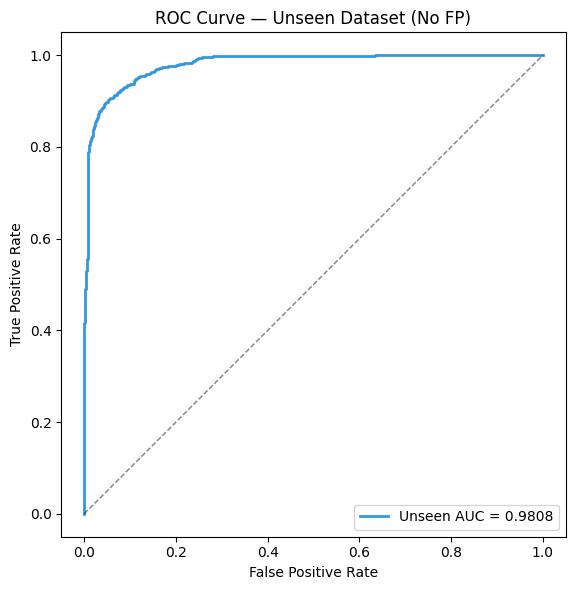

In [11]:
fpr, tpr, _ = roc_curve(true_np, pred_np)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color="#3498db", lw=2, label=f"Unseen AUC = {roc_auc:.4f}")
ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve — Unseen Dataset (No FP)")
ax.legend(loc="lower right")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 8 · Confusion Matrix + Embedding Visualization

The 64-dim fused embedding from the No-FP DualCircuit PI-HLNN is projected to 2D via PCA.
Each point is colored by its confusion matrix category (TN, TP, FP, FN).

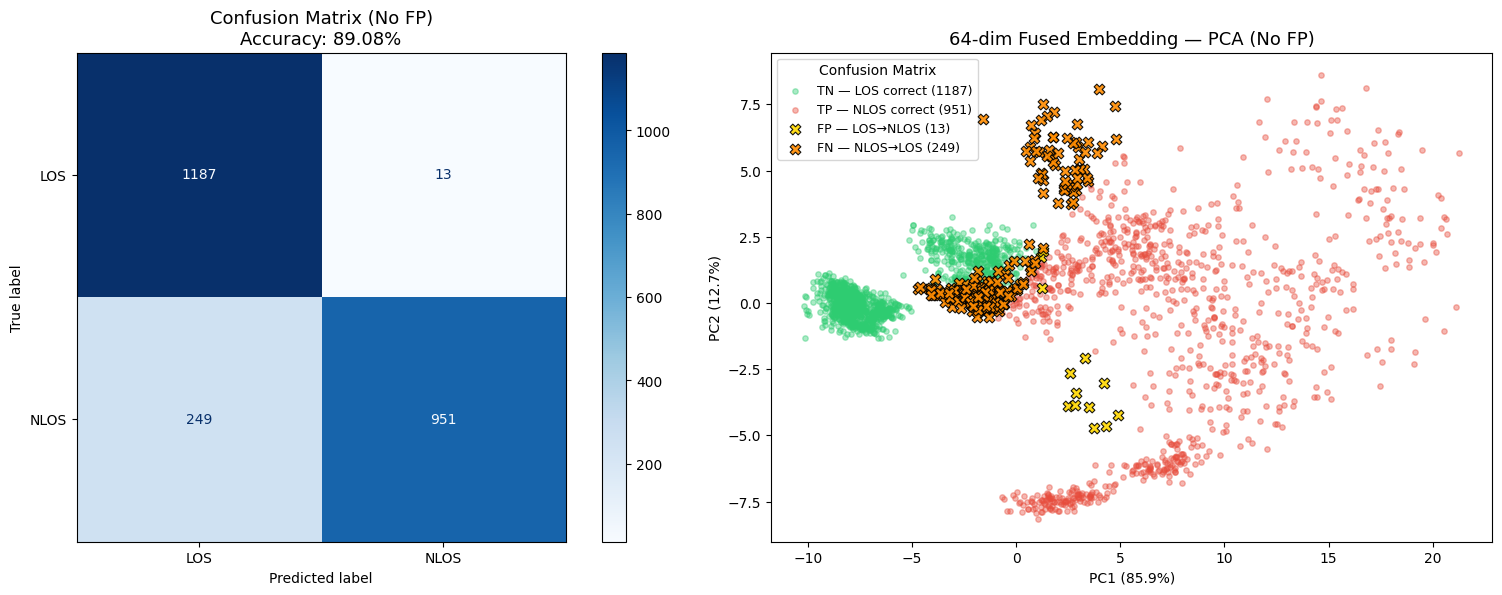

TN: 1187 | FP: 13 | TP: 951 | FN: 249 | Total: 2400


In [12]:
los_mask = true_np == 0
nlos_mask = true_np == 1

with torch.no_grad():
    embeddings = model.embed(X_te).cpu().numpy()

scaler = StandardScaler()
emb_scaled = scaler.fit_transform(embeddings)
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_scaled)

# Confusion matrix categories
misclassified = true_np != pred_label_np
los_correct = los_mask & ~misclassified    # TN
los_wrong = los_mask & misclassified       # FP
nlos_correct = nlos_mask & ~misclassified  # TP
nlos_wrong = nlos_mask & misclassified     # FN

tn = int(los_correct.sum())
fp = int(los_wrong.sum())
tp = int(nlos_correct.sum())
fn = int(nlos_wrong.sum())

# --- Side-by-side: Confusion Matrix + PCA Embedding ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Confusion Matrix
cm = confusion_matrix(true_np, pred_label_np)
disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
disp.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title(f"Confusion Matrix (No FP)\nAccuracy: {100*accuracy:.2f}%", fontsize=13)

# Right: PCA scatter
ax = axes[1]

ax.scatter(emb_2d[los_correct, 0], emb_2d[los_correct, 1],
           c="#2ecc71", alpha=0.4, s=15,
           label=f"TN \u2014 LOS correct ({tn})", zorder=3)
ax.scatter(emb_2d[nlos_correct, 0], emb_2d[nlos_correct, 1],
           c="#e74c3c", alpha=0.4, s=15,
           label=f"TP \u2014 NLOS correct ({tp})", zorder=3)
if fp > 0:
    ax.scatter(emb_2d[los_wrong, 0], emb_2d[los_wrong, 1],
               c="gold", marker='X', s=60, edgecolors='black', linewidths=0.8,
               alpha=0.9, label=f"FP \u2014 LOS\u2192NLOS ({fp})", zorder=7)
if fn > 0:
    ax.scatter(emb_2d[nlos_wrong, 0], emb_2d[nlos_wrong, 1],
               c="darkorange", marker='X', s=60, edgecolors='black', linewidths=0.8,
               alpha=0.9, label=f"FN \u2014 NLOS\u2192LOS ({fn})", zorder=7)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("64-dim Fused Embedding — PCA (No FP)", fontsize=13)
ax.legend(loc="upper left", fontsize=9, title="Confusion Matrix", title_fontsize=10)

plt.tight_layout()
plt.show()

print(f"TN: {tn} | FP: {fp} | TP: {tp} | FN: {fn} | Total: {tn+fp+tp+fn}")

## 9 · Prediction Confidence Distribution

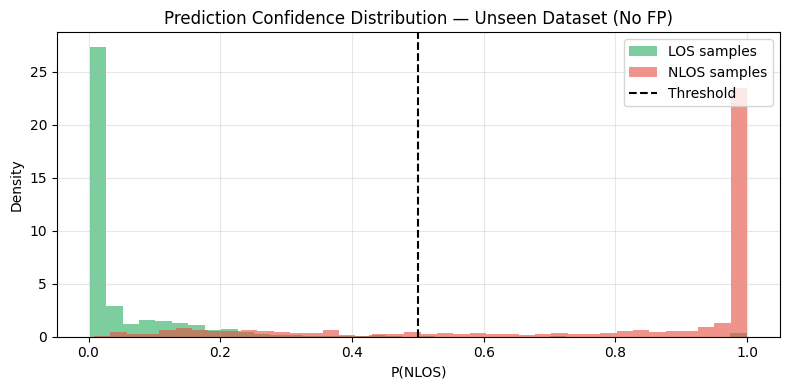

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(pred_np[true_np == 0], bins=40, alpha=0.6, color="#27ae60",
        label="LOS samples", density=True)
ax.hist(pred_np[true_np == 1], bins=40, alpha=0.6, color="#e74c3c",
        label="NLOS samples", density=True)
ax.axvline(0.5, color="black", ls="--", lw=1.5, label="Threshold")
ax.set_xlabel("P(NLOS)")
ax.set_ylabel("Density")
ax.set_title("Prediction Confidence Distribution — Unseen Dataset (No FP)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10 · Tau Distribution (LOS vs NLOS circuits)

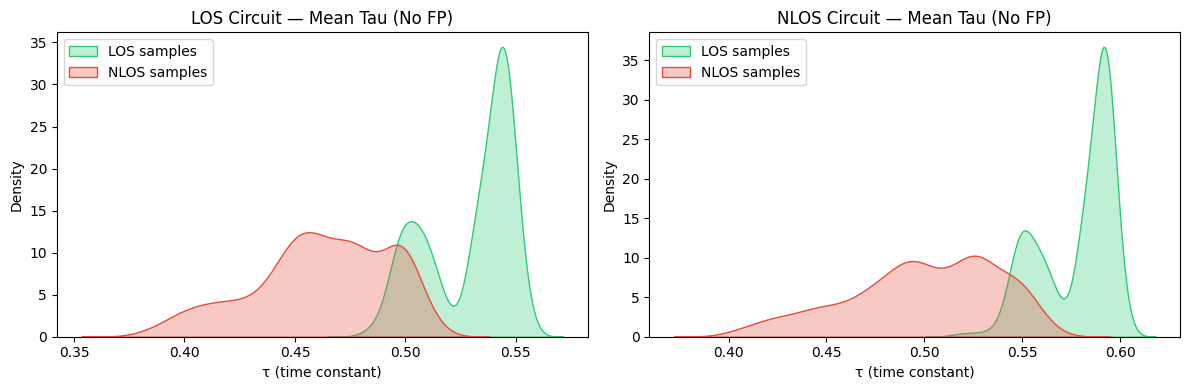

In [14]:
with torch.no_grad():
    _, _, _, tau_los_hist, tau_nlos_hist, _, _ = model(
        X_te, return_dynamics=True
    )
    tau_los_vals = tau_los_hist.mean(dim=(1, 2)).cpu().numpy()
    tau_nlos_vals = tau_nlos_hist.mean(dim=(1, 2)).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# LOS circuit tau
sns.kdeplot(tau_los_vals[true_np == 0], ax=axes[0], color="#2ecc71",
            fill=True, alpha=0.3, label="LOS samples")
sns.kdeplot(tau_los_vals[true_np == 1], ax=axes[0], color="#e74c3c",
            fill=True, alpha=0.3, label="NLOS samples")
axes[0].set_title("LOS Circuit \u2014 Mean Tau (No FP)")
axes[0].set_xlabel("\u03c4 (time constant)")
axes[0].legend()

# NLOS circuit tau
sns.kdeplot(tau_nlos_vals[true_np == 0], ax=axes[1], color="#2ecc71",
            fill=True, alpha=0.3, label="LOS samples")
sns.kdeplot(tau_nlos_vals[true_np == 1], ax=axes[1], color="#e74c3c",
            fill=True, alpha=0.3, label="NLOS samples")
axes[1].set_title("NLOS Circuit \u2014 Mean Tau (No FP)")
axes[1].set_xlabel("\u03c4 (time constant)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 11 · Misclassified Samples Analysis

In [15]:
misclassified = true_np != pred_label_np
n_wrong = misclassified.sum()

if n_wrong == 0:
    print("No misclassified samples — perfect accuracy on unseen data!")
else:
    print(f"Misclassified: {n_wrong} / {len(true_np)} ({100*n_wrong/len(true_np):.2f}%)")
    print(f"\n{'Source File':<28} {'True':>6} {'Pred':>6} {'P(NLOS)':>9}")
    print("-" * 55)

    mis_idx = np.where(misclassified)[0]
    for i in mis_idx[:30]:
        lbl = "NLOS" if true_np[i] == 1 else "LOS"
        plb = "NLOS" if pred_label_np[i] == 1 else "LOS"
        print(f"{sources[i]:<28} {lbl:>6} {plb:>6} {pred_np[i]:>9.4f}")

    if len(mis_idx) > 30:
        print(f"... and {len(mis_idx) - 30} more")

    # Per-scenario misclassification breakdown
    print(f"\n{'Scenario':<16} {'Errors':>7} {'Total':>7} {'Error Rate':>11}")
    print("-" * 45)
    for scenario in unique_scenarios:
        mask = scenario_names == scenario
        errs = (true_np[mask] != pred_label_np[mask]).sum()
        total = mask.sum()
        if errs > 0:
            print(f"{scenario:<16} {errs:>7} {total:>7} {100*errs/total:>10.2f}%")

Misclassified: 262 / 2400 (10.92%)

Source File                    True   Pred   P(NLOS)
-------------------------------------------------------
9.54m_nlos_c2.csv              NLOS    LOS    0.3188
9.54m_nlos_c2.csv              NLOS    LOS    0.4463
9.54m_nlos_c2.csv              NLOS    LOS    0.2355
9.54m_nlos_c2.csv              NLOS    LOS    0.1634
9.54m_nlos_c2.csv              NLOS    LOS    0.2883
9.54m_nlos_c2.csv              NLOS    LOS    0.3140
9.54m_nlos_c2.csv              NLOS    LOS    0.4954
9.54m_nlos_c2.csv              NLOS    LOS    0.2433
9.54m_nlos_c2.csv              NLOS    LOS    0.1509
9.54m_nlos_c2.csv              NLOS    LOS    0.4495
9.54m_nlos_c2.csv              NLOS    LOS    0.3601
9.54m_nlos_c2.csv              NLOS    LOS    0.1272
9.54m_nlos_c2.csv              NLOS    LOS    0.1703
9.54m_nlos_c2.csv              NLOS    LOS    0.1511
9.54m_nlos_c2.csv              NLOS    LOS    0.1765
9.54m_nlos_c2.csv              NLOS    LOS    0.2351
9.54m_n

In [16]:
print("Unseen dataset evaluation complete (No FP).")
print("\nCompare with:")
print("  PI-HLNN + FP:  stage1_unseen_test.ipynb")
print("  PI-HLNN No FP: this notebook")

Unseen dataset evaluation complete (No FP).

Compare with:
  PI-HLNN + FP:  stage1_unseen_test.ipynb
  PI-HLNN No FP: this notebook
